# Use SAS DLPy to Create CNN EfficientNet Image Classification Models 

## Image Classification with EfficientNet
The [EfficientNet](https://arxiv.org/pdf/1905.11946.pdf) architecture provides a simple and efficient way to improve convolutional neural network model performance by simultaneously scaling  network depth, width, and resolution. This notebook example shows how to use SAS DLPy to create an EfficientNet image classification model that obtains great accuracy. 

This example uses the Fruits-360 data from the [Horea94 GitHub repository](https://github.com/Horea94/Fruit-Images-Dataset), [with permission](https://github.com/Horea94/Fruit-Images-Dataset/blob/master/LICENSE) from Minai Oltean and Horea Murasan. A zip archive that contains the Fruits-360 `Training` and `Test` data sets can be downloaded from the open-source repository [here](https://github.com/Horea94/Fruit-Images-Dataset/archive/master.zip)(708MB). 

This end-to-end example creates and trains two SAS Viya EfficientNet models that classify images of 120 fruit and vegetable types. The smaller model is deployed in SAS Analytic Store (ASTORE) format, where it can be used in another environment to score new data. The Image Classification with EfficientNet notebook example follows this sequence:

- [Important Note: Client and Server Definitions](#ClientServer)
- [Import Python Utility and SAS DLPy  Modules](#import-packages)
- [Download the Fruits-360 Training and Test Data](#downloadData)
- [Start a SAS CAS Session](#StartCAS) 
- [Partition and Load Images into CAS Train and Test Tables](#prepare-image-datasets) 
     - [Examine the Train and Test Data in SAS CAS](#ReviewData)                
- [Use SAS DLPy to Create an EfficientNet Image Classification Model](#image-classification-efficientnet)
    - [Define the SAS Viya EfficientNet Model Architecture](#build-effb0)
    - [Display Summary of Model Architecture](#summary_b0)
    - [Train the SAS Viya EfficientNet Model](#train-effb0)
    - [Assess SAS Viya EfficientNet Model Performance](#evaluate-effb0)
- [Use SAS DLPy to Create a Smaller SAS Viya EfficientNet Model](#build-smaller-effb0)
    - [Define the SAS Viya Smaller EfficientNet Model Architecture](#defineSmaller)
    - [Display Summary of Smaller EfficientNet Model Architecture](#summarizeSmaller)
    - [Train the Smaller SAS Viya EfficientNet Model](#train-smaller-effb0)
    - [Assess Smaller SAS Viya EfficientNet Model Performance](#evaluate-smaller-effb0) 
- [Save the SAS Viya Smaller EfficientNet Model and Deploy for Scoring](#deployment)
- [SAS Viya EfficientNet Image Classification Example Summary](#summary)
- [References](#References)

<a id="ClientServer"></a>

## Important Note: Client and Server Definitions
SAS Viya literature and technical documentation often refers to client and server entities. In this scenario, the client is the computer that runs the Jupyter notebook with the example code. The server is the computer that is running the Viya server. These two computers might (or might not) use the same operating system, and might (or might not) have access to a common file system.

This notebook assumes that the client and server do not use the same operating system, but that they do have access to a common file system. If the client and server in your environment do not have access to a common file system, you will need to copy or transfer files between client and server during this example.


In [1]:
# This code defines path variables that contain path specifications to  
# the client and server machine weight files and image root directories

# Server EfficientNet root location (your path will be different)
server_efficient_root = r'/cas/DeepLearn/UserID/EfficientNet/'  # this is the SERVER_EFFICIENT_ROOT directory

# Server EfficientNet image root location (your path will be different)
server_efficient_image_root = r'/cas/DeepLearn/UserID/EfficientNet/Fruits'  # this is the SERVER_EFFICIENT_IMAGE_ROOT directory

# Client EfficientNet root location (your path will be different)
client_efficient_root = r'\\network\root\data\UserID\EfficientNet'  # this is the CLIENT_EFFICIENT_ROOT directory

 <a id="import-packages"></a>

## Import Python Utility and SAS DLPy  Modules
This step imports the various Python utilities and SAS DLPy modules that support functions and output used in this example.

<b>Note:</b>The SAS DLPy [EfficientNet package](https://github.com/sassoftware/python-dlpy/blob/master/dlpy/applications/efficientnet.py) is a new feature that is available from the SAS DLPy repository, but is not yet available in the most recent installed version of SAS DLPY (1.2.0.)

In [ ]:
# OPTIONAL STEP: Check your SAS DLPy Version
print(dlpy.__version__)

If you are using SAS DLPy version 1.2.0 or earlier, you will need to clone the [latest SAS DLPy repository](https://github.com/sassoftware/python-dlpy) to your client system and update your system path. This task enables you to access and use the new EfficientNet model package in DLPy.

If your DLPy version is greater than 1.2.0, skip the following code and proceed to the next step. 

In [2]:
# If you are running SAS DLPy version 1.2.0 or earlier, you must 
# clone the DLPy repository and update your client environment's 
# Python fork for SAS DLPy. 

# After updating the DLPy fork on your client, use 'sys.path.insert()' 
# to update your system path so it includes the updated Python DLPy 
# fork with the new SAS DLPy efficientnet.py package.

# Import Python 'sys' module
import sys

# Insert the updated Python DLPy fork path into the client system path.
# Your path will be different from the one shown below.
sys.path.insert(0, r'c:\Users\UserID\python-dlpy-1')

# Display the updated client system path. The updated path content  
# should be the first path in the list.

print(sys.path)


Import the various Python and SAS DLPy packages that will be used in this notebook session. Begin by importing the SAS Statistical Wrapper for Anlaytic Transactions (SWAT). SWAT is the Python interface to SAS CAS. You can find more detailed information about starting a SAS CAS session with the SWAT package [here](https://sassoftware.github.io/python-swat/getting-started.html).

In [3]:
# Import Python and SAS DLPy Utilities

# SAS Statistical Wrapper for Analytic Transfer (SWAT)
import swat as sw

# Numpy, Pandas, and Matplotlib Python tools for 
# analytic statistics and output plots
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Display Matplotlib output in notebook cells
%matplotlib inline

# Warning messages
import warnings

#SAS DLPy Modules
from dlpy import Model, Sequential
from dlpy.model import *
from dlpy.layers import *
from dlpy.applications import *
from dlpy.utils import *
from dlpy.images import ImageTable
from dlpy.splitting import two_way_split
from dlpy.model import Optimizer
from dlpy.lr_scheduler import *

# DLPy EfficientNet module
from dlpy.applications import EfficientNetB0

In [4]:
# OPTIONAL STEP:
# Use 'help' request to verify that 
# the EfficientNet module is loaded

help(EfficientNetB0)

# If the Help for function 'EfficientnetB0' does not load, 
# your system is not accessing the updated DLPy content. 
# Verify the Python file update and the environment path update. 

<a id='downloadData'></a>
        
<h2>Download the Fruits-360 Training and Test Data</h2>

If you have not already done so, you can download all of the required data for this notebook example in a zip file from the open-source [Horea94 Fruits-360 repository](https://github.com/Horea94/Fruit-Images-Dataset) on GitHub. You can directly download the Horea94 2018 Fruit-Images-Dataset [here](https://github.com/Horea94/Fruit-Images-Dataset/archive/master.zip)(708MB). 

The `Fruit-Images-Dataset-Master` zip archive contains `Training` and `Test` folders, each with subfolders for 120 labeled classes of fruit and vegetable images. The `Training` image folder contains 61,488 images. The `Test` image folder contains 20,622 images. The images are all 100px by 100px. Only the `Training` and `Test` folders (always include `LICENSE` and `readme` files) from the archive are required to complete this notebook example.

Expand the `Training` and `Test` folders to the `server_efficient_image` path location that you defined in the prior [Client and Server Definitions](#ClientServer) code block. The expanded content should be structured as follows:

<h5> Server path to `server_efficient_image_root`</h5> 

* `Training`
    * Apple Braeburn
        * (images)       
    * Apple Crimson Snow
        * (images)
    * Apple Golden 1
        * (images)
    * ...
    * ...
    * Tomato Maroon
        * (images)
    * Tomato Yellow
        * (images)
    * Walnut
        * (images)
        
        

* `Test`
    * Apple Braeburn
        * (images)       
    * Apple Crimson Snow
        * (images)
    * Apple Golden 1
        * (images)
    * ...
    * ...
    * Tomato Maroon
        * (images)
    * Tomato Yellow
        * (images)
    * Walnut
        * (images)    


<a id="StartCAS"></a>


## Start A SAS CAS Session

Initiate a session on your SAS CAS server, and load the SAS CAS action sets that this notebook example requires.

In [5]:
# Start a CAS session.
# Your server name and portID will be different.

s = sw.CAS('server-name.unx.your-company.com', 5570)
s.loadactionset('image')
s.loadactionset('deepLearn')
s.loadactionset('astore')

NOTE: Added action set 'image'.
NOTE: Added action set 'deepLearn'.
NOTE: Added action set 'astore'.


[actionset]

 'astore'

+ Elapsed: 0.000903s, sys: 0.000873s, mem: 0.204mb

<a id="prepare-image-datasets"></a>

## Partition and Load Images into CAS Training and Test Tables

This step partitions and loads the downloaded Fruits-360 images into SAS CAS train and test tables named `trainImgTbl` and `testImgTbl`. The Train and Test image file locations are specified by concatenating the destination folder name with the path stored in `server_efficient_image_root`.

In [6]:
# load training data set images into CAS table trainImgTbl
trainImgTbl = ImageTable.load_files(s, path=server_efficient_image_root+'/Training', casout=dict(name='train'))

# load test data set images into CAS table testImgTbl
testImgTbl = ImageTable.load_files(s, path=server_efficient_image_root+'/Test', casout=dict(name='test'))

# Display the number of images in the newly partitioned 
# Train table 'trainImgTbl' and Test table 'testImgTbl'.
print("Number of images for training:", trainImgTbl.numrows()["numrows"])
print("Number of images for validation:", testImgTbl.numrows()["numrows"])

Number of images for training: 61476
Number of images for validation: 20618


<a id="ReviewData"></a>

## Examine the Train and Test Data in SAS CAS

This section displays random images from the newly created SAS CAS `trainImgTbl` and `testImgTable` tables, and then generates metadata summaries for both tables.

- [Display Randomly Selected Train Images](#randTrainImages)
- [Display Randomly Selected Test Images](#randTestImages)
- [Summarize the Training and Test Image Metadata](#summarizeImages)
- [Display Frequency Distribution of Training Data Classes](#frequencyDistribution)
- [Partition the CAS Train Table into Smaller Train and Validation Tables](#PartitionTables)

<a id='randTrainImages'></a>

### Display Randomly Selected Train Images

Use the `show()` function to display 6 random images from the newly created CAS table `trainImgTbl` in a 3-columnn array.

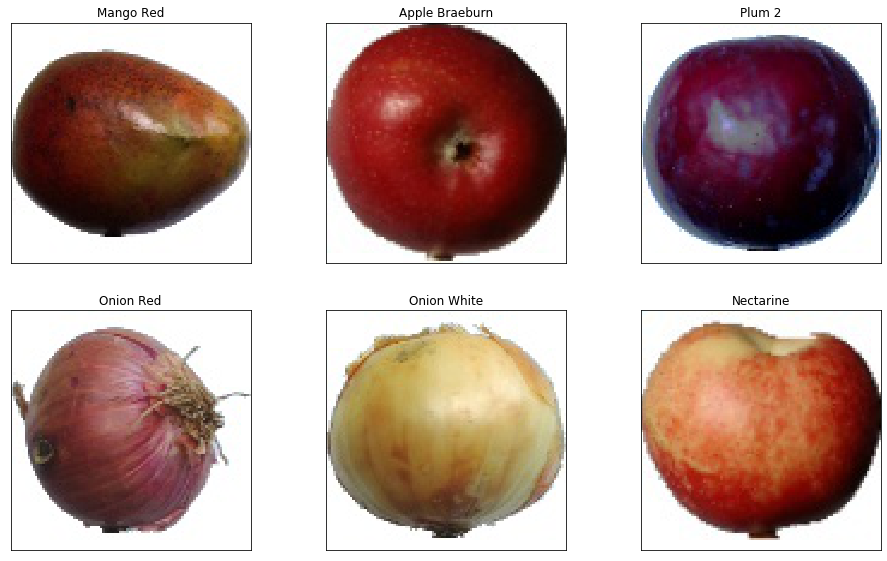

In [7]:
trainImgTbl.show(6,ncol=3,randomize=True)

<a id='randTestImages'></a>

### Display Randomly Selected Test Images

Use the `show()` function to display 6 random images from the newly created CAS table `testImgTbl` in a 3-columnn array:

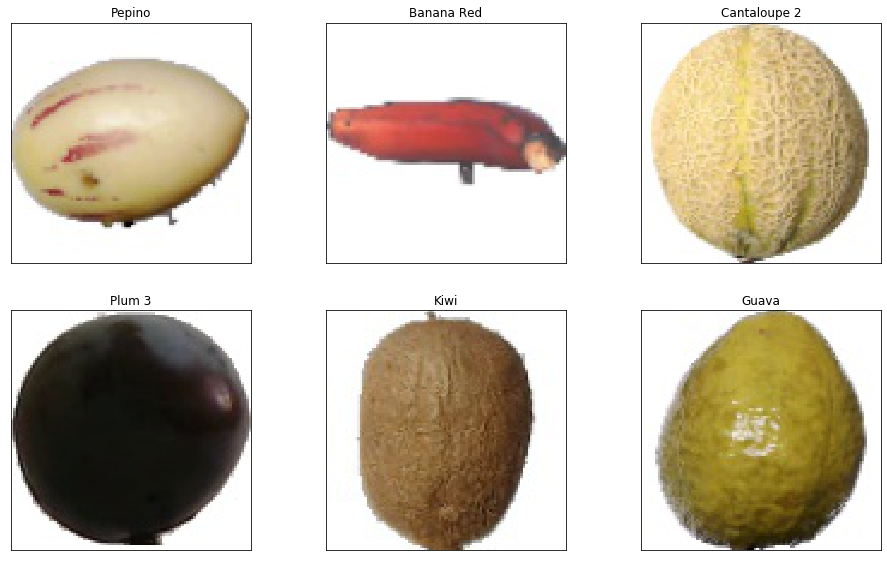

In [8]:
testImgTbl.show(6,ncol=3,randomize=True)

<a id='summarizeImages'></a>

### Summarize the Training and Test Image Metadata

Use the `image_summary` command to display image size and channel metadata for the train `trnImgTbl` and test `testImgTbl` CAS image tables. The information includes the number of images, image size distribution, and the mean value for each of the BGR channels. BGR channel mean values are often used as offset values during model training.

In [9]:
# Summary information for the train image data
trainImgTbl.image_summary

jpg                 61476
minWidth              100
maxWidth              100
minHeight             100
maxHeight             100
meanWidth             100
meanHeight            100
mean1stChannel    126.541
min1stChannel           0
max1stChannel         255
mean2ndChannel    146.286
min2ndChannel           0
max2ndChannel         255
mean3rdChannel    174.226
min3rdChannel           0
max3rdChannel         255
dtype: object

<b>Note:</b> The summary table above shows that there are 61,476 images with image size (100px by 100px) in the training data set.
The channel mean values calculated here will be used as BGR offset values to normalize image inputs when the model is trained.

In [10]:
# Summary information for the test image data
testImgTbl.image_summary

jpg                 20618
minWidth              100
maxWidth              100
minHeight             100
maxHeight             100
meanWidth             100
meanHeight            100
mean1stChannel    129.711
min1stChannel           0
max1stChannel         255
mean2ndChannel    149.189
min2ndChannel           0
max2ndChannel         255
mean3rdChannel    176.062
min3rdChannel           0
max3rdChannel         255
dtype: object

<b>Note:</b> The summary table above shows that there are 20,618 images with image size (100px by 100px) in the test data set.

<a id='frequencyDistribution'></a>

### Display Frequency Distribution of Training Data Classes

Generate a frequency chart that displays the distribution of the fruit and vegetable images by class in the training data set. The chart should contain row data for each of 120 classes:

In [11]:
freq= trainImgTbl.label_freq
print("The minimum number of images among each class: ", np.min(freq["Frequency"]))
print("The maximum number of images among each class: ", np.max(freq["Frequency"]))
print(freq)

The minimum number of images among each class:  297
The maximum number of images among each class:  984
Frequency for TRAIN

                    Level  Frequency
Apple Braeburn          1        492
Apple Crimson Snow      2        444
Apple Golden 1          3        480
Apple Golden 2          4        492
Apple Golden 3          5        481
...                   ...        ...
Tomato 4              116        479
Tomato Cherry Red     117        492
Tomato Maroon         118        367
Tomato Yellow         119        459
Walnut                120        735

[120 rows x 2 columns]


The training table frequency chart shows 120 fruit and vegetable classes. The number of images in each class ranges from 297 to 984.

<a id='PartitionTables'></a>


### Partition the CAS Train Table into Smaller Train and Validation Tables

The current SAS CAS session has a `Training` image table that contains 61,488 labeled images, and a `Test` image table that contains contains 20,622 labeled images. These folders cam be used for deep learning model training and validation tasks.

However, sometimes smaller train and validation data sets are useful. This step uses SAS DLPy and the `Training` image table to create smaller CAS input data tables named `train_data` and `validation_data`. This notebook uses the smaller tables in subsequent EfficientNet model training and validation functions.

Use the SAS DLPy `two_way_split()` function to partition the contents of the `Training` image folder. Setting the `test_rate` parameter to 15% means that 85% of the 61,488 (52,223) images from table `Training` are allocated to the new train role table named `train_data`, and the remaining 15% (9,265) images are allocated to the new test role table named `test_data`. 

In [12]:
# Partition the images in CAS table 'trainImgTbl' into smaller
# image tables named 'train_data' and 'validation_data'.

train_data, validation_data = two_way_split(trainImgTbl, 
                                            test_rate=15, 
                                            seed=12345
                                           )

Use the `numrows()` function to display the number of rows (images) in the newly generated CAS tables `train_data` and `validation_data`. The output should confirm that there are the expected number of images in each table: 52,223 in `train_data` and 9,253 in `validation_data`.

In [14]:
# Display the number of images in the new tables
# 'train_data' and 'validation_data'
print("Number of images in train_data:", train_data.numrows()["numrows"])
print("Number of images in validation_data:", validation_data.numrows()["numrows"])

Number of images in train_data: 52223
Number of images in validation_data: 9253


<a id="image-classification-efficientnet"></a>

## Use SAS DLPy to Create an EfficientNet Image Classification Model 

EfficientNet models are a family of CNN models. EfficientNet models range from a baseline network (EfficientNet-B0) and scale upwards (EfficientNet-B1 to EfficientNet-B7).  You can use SAS DLPy to build SAS Viya EfficientNet models that can be deployed to score new data. 

The [EfficientNet paper](https://arxiv.org/pdf/1905.11946.pdf) by Tan and Le shows how the EfficientNet-B0 model achieves slightly better accuracy when compared to a ResNet50 model, and is up to 75% smaller in size than the ResNet50 model.  This example notebook begins by creating an EfficientNet-B0 model to perform image classification on a 120-class fruit and vegetable image collection.  

 <a id="build-effb0"></a>

### Define the SAS Viya EfficientNet-B0 Model Architecture

Use the SAS DLPy `EfficientNetB0()` function to define an EfficientNet-B0 image classification model.

The function parameters specify a model with `n_classes=120`, one for each of the 120 object classes in the Fruits-360 image data. The architecture uses BGR `offsets` and `norm_standards` to normalize the input image values. These steps often improve model convergence. The input images are augmented by performing `random_flip`, `random_crop`, and `random_mutation` operations during training. Image augmentation helps to train models that generalize better, and often improves model accuracy.

The  images in the input layer have an input shape of 224px by 224 px by 3 (BGR channels). The `random_crop` option `resizethencrop` conveniently resizes the input data shape dimensions for use with an EfficientNet-B0 network. 

In [17]:
## Instantiate an EfficientNetB0 model
# BGR offset values from training
offsets = [126.519793, 146.276162,174.217395]

# Normalization standards
norm_stds = [255/2.,255/2.,255/2.]

# Specify EfficientNet B0 Model Parameters                          
effnetb0 = EfficientNetB0(conn=s, 
                          # 120 classes
                          n_classes=120,
                          
                          # BGR offset values
                          offsets=offsets, 
                          
                          # Normalization values
                          norm_stds=norm_stds,
                          
                          # Perform random flips to augment data
                          random_flip="hv", 
                          
                          # Perform random crops to augment data
                          random_crop="resizethencrop", 
                          
                          # Perform random  mutations to augment data
                          random_mutation="random"
                         )     

NOTE: Model compiled successfully.


<a id='summary_b0'></a>

### Display Summary of SAS Viya EfficientNet-B0  Model Architecture

Use the DLPy `print_summary()` function to display and verify the input and output layers for the new EfficientNet-B0 model `effnetb0`. 

 The output layer for the model `effnetb0` is a classification layer with 120 classes. 

The EfficientNet-B0 model `effnetb0` has around 4.2 million parameters. By comparison, the popular ResNet-50 model image classification model has over 23 million parameters!

In [18]:
effnetb0.print_summary()

,Layer Id,Layer,Type,Kernel Size,Stride,Activation,Output Size,Number of Parameters,FLOPS(forward pass)
0,0,data,input,,,None,"(224, 224, 3)","(0, 0)",0
1,1,Conv1,convo,"(3, 3)","(2, 2)",Identity,"(112, 112, 32)","(864, 0)",10838016
2,2,bn_Conv1,batchnorm,,,Relu,"(112, 112, 32)","(0, 64)",0
3,3,stage_1_block_0depthwise,groupconvo,"(3, 3)","(1, 1)",Identity,"(112, 112, 32)","(288, 0)",3612672
4,4,stage_1_block_0depthwise_BN,batchnorm,,,Relu,"(112, 112, 32)","(0, 64)",0
...,...,...,...,...,...,...,...,...,...
178,178,Conv_top_bn,batchnorm,,,Relu,"(7, 7, 1280)","(0, 2560)",0
179,179,Global_avg_pool,pool,"(7, 7)","(1, 1)",Mean,"(1, 1, 1280)","(0, 0)",0
180,180,OutputLayer_2,output,,,Softmax,120,"(153600, 120)",0
181,,,,,,,,Total number of parameters,Total FLOPS


<a id="train-effb0"></a>

### Train the SAS Viya EfficientNet-B0 Model

Next, train the newly-created SAS Viya EfficientNet-B0 image classification model from scratch. 

- [Specify SAS DLPy EfficientNet-B0 Model Training Parameter Values](#TrainParams)
- [Fit the SAS Viya EfficiencyNet-B0 Model](#fitModel)
- [Display SAS Viya EfficiencyNet-B0 Model Accuracy Plots for Train and Validation Data](#accuracyPlots)

<b>Note:</b> Training times vary from environment to environment. Training an EfficientNet model with 120 classes for 80 epochs will likely require an hour or more.


<a id='TrainParams'></a>

#### Specify SAS DLPy EfficientNet-B0 Model Training Parameter Values 

Before fitting the model, save the parameter values that will be used during model training to variables that match the parameter names. This approach makes for cleaner model training code and facilitates easier troubleshooting. 

In [19]:
# Variable for Number of Epochs
nEpoch=80

# Variable for Number of Threads
nThread=4

# Variable for Batch Size
batchSize=128

# Calculate miniBatch Size
miniBatch=math.ceil(batchSize/nThread)

# Define Learning Rate scheduler parameters
lr_scheduler=ReduceLROnPlateau(conn=s, 
                               cool_down_iters=3, 
                               gamma=0.8, 
                               learning_rate=0.001, 
                               patience=5
                               )

# Define Momentum Solver parameters
solver=MomentumSolver(lr_scheduler=lr_scheduler,
                      clip_grad_max = 100, 
                      clip_grad_min = -100
                      )                       

# Define Solver optimizer parameter settings
optimizer=Optimizer(seed=12345, 
                    algorithm=solver, 
                    mini_batch_size = miniBatch, 
                    log_level=2, 
                    max_epochs=nEpoch, 
                    reg_l2=0.0005
                    )

## Run using two GPUs
gpu=Gpu(devices=[0,1])

The following argument(s) learning_rate, gamma, step_size, power are overwritten by the according arguments specified in lr_scheduler.


<a id='fitModel'></a>

#### Fit the SAS Viya EfficiencyNet-B0 Model

The next step uses the SAS DLPy `model.fit()` function to train the `effnetb0` model from scratch, using the parameter value variables that were defined in the previous code block. Before beginning the training, review the model structure and model optimization parameter settings. 

<b>Note:</b> Training this 120-class model from scratch for 80 epochs will likely require an hour or longer. Set your expectations accordingly.

In [20]:
# Create new EfficiencyNet-B0 model named `effnetb0`
# Set variable 'model' to 'effnetb0'
model=effnetb0

# Display model structure for 'model'
print(model.model_name)

# Display model optimization parameters
print(dict(batchSize=batchSize, 
           nThread=nThread, 
           nEpoch=nEpoch
          )
     )

# Train the model using parameter settings saved to parameter 
# name variables

                          # Use the 'train_data' table created 
                          # during the previous partitioning step.
train_history = model.fit(data = train_data,
                          
                          # Use the 'validation_data' table created 
                          # during the previous partitioning step.
                          valid_table = validation_data,
                          
                          n_threads=nThread, 
                          record_seed=13309, 
                          optimizer=optimizer,
                          inputs = ['_image_'], 
                          gpu = gpu,
                          
                          # Train model from scratch
                          # Do not use h5 weight file.
                          train_from_scratch =True
                         )


EfficientNetB0
{'batchSize': 128, 'nThread': 4, 'nEpoch': 80}
NOTE: Training from scratch.
NOTE: Using server-name.unx.your-company.com: 2 out of 2 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 4161268.
NOTE:  The approximate memory cost is 411.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       6.52 (s).
NOTE:  The total number of threads on each worker is 4.
NOTE:  The total mini-batch size per thread on each worker is 32.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 128.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:    120
NOTE:  Levels for the target variable:
NOTE:  Level      0: Apple Braeburn     
NOTE:  Level      1: Apple Crimson Snow 
NOTE:  Level      2: Apple Golden 1     
NOTE:  Level      3: Apple Golden 2     
NOTE:  Level      4: Apple Golden 3     
NOTE:  Level      5: Apple Granny Smith 
NOTE:  Level    

NOTE:  29        0.001         0.01882   0.002738         0.008786         0.001513    57.24
NOTE:  30        0.001         0.01936   0.003274          0.01061        0.0009727    57.23
NOTE:  31        0.001         0.01716    0.00224          0.01942         0.004107    57.22
NOTE:  32        0.001         0.01539    0.00203          0.01895         0.003458    57.16
NOTE:  33        0.001         0.01757   0.002566           0.0112         0.001297    57.16
NOTE:  34        0.001         0.01424   0.001896          0.02816         0.007349    57.19
NOTE:  35        0.001          0.0138   0.001934          0.03068         0.008754    57.24
NOTE:  36        0.001         0.01372     0.0018         0.009088         0.001513    57.39
NOTE:  37        0.001         0.01457   0.002106          0.01186         0.002594    57.24
NOTE:  38        0.001         0.01566   0.002259         0.006554         0.001081    57.26
NOTE:  39        0.001         0.01284   0.001723          0.02076    

<a id='accuracyPlots'></a>


#### Display SAS Viya Model Accuracy Plots   

After training the SAS Viya EfficientNet-B0 model, use the model training history to display plots of the model accuracy for both train and validation data sets. The plots show that the EfficientNet model converges quickly. There is not much difference between the model classification accuracy on  the `Train` and `Validation` data sets. That is a good sign: small differences between train and test partition accuracies usually means that the training data is not overfitted.

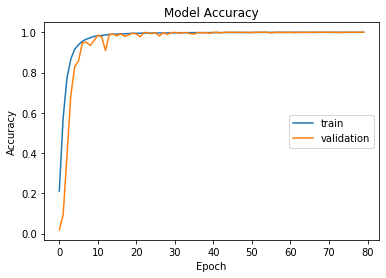

In [21]:
# summarize history for model accuracy
history = train_history["OptIterHistory"]
plt.plot(1.-history["FitError"])
plt.plot(1.-history["ValidError"])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='center right')

plt.show()

<a id="evaluate-effb0"></a>

### Assess the SAS Viya EfficientNet-B0 Model Performance

Assess the performance of the SAS Viya EfficientNet-B0 model performance by using the trained model `effnetb0` to score the validation data in the large SAS CAS test data table `testImgTbl`.

Use the SAS DLPy `dlScore()` function to score the data and display the model misclassification statistics: 

In [22]:
s.dlScore(table=testImgTbl,
          modelTable=model.model_name,
          initWeights=model.model_weights.name,
          gpu=1, 
          topprobs=5
         )

NOTE: Using server-name.unx.your-company.com: 2 out of 2 available GPU devices.


,Descr,Value
0,Number of Observations Read,20618
1,Number of Observations Used,20618
2,Misclassification Error (%),0.873024
3,Top 5 Misclassification Error (%),0.130954
4,Loss Error,0.032379


After scoring on the test images, the EfficientNet model achieves over 99% accuracy.

<a id="build-smaller-effb0"></a>

## Build a Smaller SAS Viya EfficientNet Model
We know that EfficientNet-B0 models can be scaled up to obtain EfficientNet-B1 to B7 models that have better accuracy. The example model shows a misclassifcation error is less than 1.0%, so the EfficientNet-B0 model is already quit accurate. 

On the other hand, applications on mobile devices can benefit from smaller models that can be run in a timely fashion with high accuracy. You can create a smaller SAS Viya EfficientNet model by scaling down the existing EfficientNet-B0 model and retain the high accuracy.

We instantiate a smaller SAS Viya EfficientNet model `effnetb0_smaller` by scaling down the SAS Viya EfficientNet-B0 network input width and depth parameter values. Here, we specify both width and height in the input layer as 100, which is the same as the image size in the training data set. Compared to the SAS Viya EfficientNet-B0 model, the depth and the width of the smaller EfficientNet model are both scaled down by a coefficient of 0.8. 


<a id='defineSmaller'></a>

### Define the SAS Viya Smaller EfficientNet Model Architecture

In [23]:
# Create a smaller version of the Viya EfficientNet-B0 model
effnetb0_smaller = EfficientNet(conn=s,                             
                                model_table="EfficientNetB0_Smaller", 
                                n_classes=120,
                                width=100, 
                                height=100, 
                                width_coefficient=0.8, 
                                depth_coefficient=0.8,
                                offsets=offsets, 
                                norm_stds=norm_stds,
                                # use image augmentation flips, crops, mutations
                                random_flip="hv", 
                                random_crop="resizethencrop", 
                                random_mutation="random"
                                )

NOTE: Model compiled successfully.


<a id='summarizeSmaller'></a>

### Display Summary of Smaller EfficientNet Model Architecture

Use the SAS DLPy `print_summary()` function to display the structure of the smaller SAS Viya EfficientNet model `effnetb0_smaller`. Compare the number of model parameters in this model to the number of parameters in the original SAS Viya EfficientNet-B0 model:

In [24]:
effnetb0_smaller.print_summary()

,Layer Id,Layer,Type,Kernel Size,Stride,Activation,Output Size,Number of Parameters,FLOPS(forward pass)
0,0,data,input,,,None,"(100, 100, 3)","(0, 0)",0
1,1,Conv1,convo,"(3, 3)","(2, 2)",Identity,"(50, 50, 24)","(648, 0)",1620000
2,2,bn_Conv1,batchnorm,,,Relu,"(50, 50, 24)","(0, 48)",0
3,3,stage_1_block_0depthwise,groupconvo,"(3, 3)","(1, 1)",Identity,"(50, 50, 24)","(216, 0)",540000
4,4,stage_1_block_0depthwise_BN,batchnorm,,,Relu,"(50, 50, 24)","(0, 48)",0
...,...,...,...,...,...,...,...,...,...
178,178,Conv_top_bn,batchnorm,,,Relu,"(4, 4, 1024)","(0, 2048)",0
179,179,Global_avg_pool,pool,"(4, 4)","(1, 1)",Mean,"(1, 1, 1024)","(0, 0)",0
180,180,OutputLayer_3,output,,,Softmax,120,"(122880, 120)",0
181,,,,,,,,Total number of parameters,Total FLOPS


The SAS Viya Smaller EfficientNet model has 2,689,616 parameters. The prior SAS Viya EfficientNet-B0 model has 4,161,268	parameters. In other words, the SAS Viya Smaller EfficientNet model has 35% fewer parameters than the SAS Viya EfficientNet-B0 model.

Next, train the smaller model, so that we can compare the accuracy of the SAS Viya Smaller EfficientNet model to the SAS Viya EfficientNet-B0 model.

<a id="train-smaller-effb0"></a>

### Train the Smaller SAS Viya EfficientNet Model

Next, train the newly-created SAS Viya Smaller EfficientNet image classification model from scratch. 

- [Specify SAS DLPy Smaller EfficientNet Model Training Parameter Values](#TrainParamsSmall)
- [Fit the Smaller SAS Viya EfficiencyNet Model](#fitModelSmall)
- [Display SAS Viya Smaller EfficiencyNet Model Accuracy Plots](#accuracyPlotsSmall)

<b>Note:</b> Expect this Smaller EfficientNet model to train in approximately a third of the time that it took to train the EfficientNet-B0 model.

<a id="TrainParamsSmall"></a>

#### Specify SAS DLPy Smaller EfficientNet Model Training Parameter Values

The SAS CAS session thus far retains the previous DLPy [training parameter values that were saved as variables](#TrainParams) matching the training parameter names. The same parameter values will also be used to train the smaller EfficientNet model. The model uses the same parameters; the scaling operations to reduce height and depth dimensions are performed by coefficients in the model definition, and not the initial parameter values.

<a id="fitModelSmall"></a>

#### Fit the Smaller SAS Viya EfficiencyNet Model

The next step uses the SAS DLPy `model.fit()` function to train the `effnetb0_smaller` model from scratch, using the parameter value variables that were defined earlier in this example. Before beginning the training, review the model structure and model optimization parameter settings: 

In [25]:
# Create New EfficiencyNet model named 'effnetb0_smaller'.

# Set variable 'model' to 'effnetb0_smaller'
model= effnetb0_smaller

# Display model structure for 'effnetb0_smaller'
print(model.model_name)


# train the model using previously defined model parameter 
# value variables

                          # Use the 'train_data' table defined in
                          # a previous partitioning step.
train_history = model.fit(data = train_data,
                          
                          # Use the 'validation_data' table defined in
                          # a previous partitioning step.
                          valid_table = validation_data,
                          
                          n_threads=nThread,  
                          record_seed=13309, 
                          optimizer=optimizer,
                          inputs = ['_image_'], 
                          gpu = gpu,
                          
                          # train from scratch
                          # do not use h5 weights file
                          train_from_scratch =True
                         )


EfficientNetB0_Smaller
NOTE: Training from scratch.
NOTE: Using server-name.unx.your-company.com: 2 out of 2 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 2689616.
NOTE:  The approximate memory cost is 103.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       3.57 (s).
NOTE:  The total number of threads on each worker is 4.
NOTE:  The total mini-batch size per thread on each worker is 32.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 128.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:    120
NOTE:  Levels for the target variable:
NOTE:  Level      0: Apple Braeburn     
NOTE:  Level      1: Apple Crimson Snow 
NOTE:  Level      2: Apple Golden 1     
NOTE:  Level      3: Apple Golden 2     
NOTE:  Level      4: Apple Golden 3     
NOTE:  Level      5: Apple Granny Smith 
NOTE:  Level      6: Apple Pink Lady    
NOTE:  Level  

NOTE:  26        0.001         0.04062   0.008904          0.04496           0.0107    15.66
NOTE:  27        0.001         0.03403   0.006166          0.01864         0.004107    15.65
NOTE:  28        0.001         0.03653   0.007947          0.05808          0.01686    15.64
NOTE:  29        0.001          0.0329   0.006491         0.009528         0.001189    15.65
NOTE:  30        0.001         0.03139   0.006051         0.006814        0.0005404    15.67
NOTE:  31        0.001         0.03099     0.0063          0.02416         0.005728    15.67
NOTE:  32        0.001          0.0279    0.00561          0.01292         0.002486    15.73
NOTE:  33        0.001            0.03   0.006242          0.02704         0.006592    15.68
NOTE:  34        0.001         0.02496   0.004404          0.01124         0.002053    15.69
NOTE:  35        0.001         0.02443   0.004155          0.01878         0.004539    15.69
NOTE:  36        0.001         0.02741   0.005802          0.01012    

<a id='accuracyPlotsSmall'></a>

#### Display SAS Viya Smaller EfficiencyNet Model Accuracy Plots


After training the SAS Viya Smaller EfficientNet model, use the model training history to display plots for the model accuracy for train and validation data sets. 

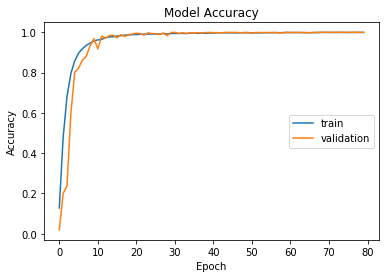

In [26]:
# summarize history for model accuracy
history = train_history["OptIterHistory"]
plt.plot(1.-history["FitError"])
plt.plot(1.-history["ValidError"])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='center right')
plt.show()

The plots show that like the SAS Viya EfficientNet-B0 model, the SAS Viya Smaller EfficientNet model also converges quickly. There is not much difference between the model classification accuracy on  the `Train` and `Validation` data sets. That is a good sign: small differences between train and test partition accuracies usually means that the training data is not overfitted. 

Even with 35% fewer model parameters, the SAS Viya Smaller EfficientNet model appears to be of similar performance to the SAS Viya EfficientNet-B0 model.

<a id="evaluate-smaller-effb0"></a> 

### Assess the SAS Viya Smaller EfficientNet Model Performance 

Assess the performance of the SAS Viya Smaller EfficientNet-B0 model performance by using the trained model `effnetb0_smaller` to score the validation data in the large SAS CAS test data table `testImgTbl`. Does the smaller EfficientNet model with 35% fewer parameters deliver the performance of the previous model?

Use the SAS DLPy `dlScore()` function to score the data with the SAS Viya Smaller EfficientNet model. Upon completion, display the model misclassification statistics: 

In [27]:
s.dlScore(table=testImgTbl,
          modelTable=model.model_name,
          initWeights=model.model_weights.name,
          gpu=1, topprobs=5)

NOTE: Using server-name.unx.your-company.com: 2 out of 2 available GPU devices.


,Descr,Value
0,Number of Observations Read,20618
1,Number of Observations Used,20618
2,Misclassification Error (%),2.022505
3,Top 5 Misclassification Error (%),0.194005
4,Loss Error,0.073871


Like its predecessor, the SAS Viya Smaller EfficientNet image classification model has a very small misclassification rate: 2.0%. This is a high-performing model, with misclassification results that are 1% higher than the EfficientNet-B0 model nearly 4 times its size. The models have essentially equivalent performance, but the latest EfficientNet model has a significantly smaller footprint and trains significantly faster than the original EfficientNet-B0 model.

<a id="deployment"></a>

## Save the SAS Viya Smaller EfficientNet Model and Deploy for Scoring 

The SAS Viya Smaller EfficientNet Model has been validated and demonstrates essentially equivalent performance to the larger SAS Viya EfficientNet-B0 model.

Deploy the SAS Viya Smaller EfficientNet model to a client location in SAS Analytic Store ([ASTORE](https://go.documentation.sas.com/?docsetId=casml&docsetTarget=viyaml_astore_gettingstarted01.htm%3Flocale&docsetVersion=8.1&locale=en)) format. A good client location to use would be the folder path that was defined in the example path variable `client_efficient_root`. The ASTORE model can be used with SAS Viya to score new data in a new environment.

In [29]:
#Save the SAS Viya Smaller EfficientNet Model as a SAS ASTORE 
# model named `effnetb0_small` for deployment as a scoring model

# Deploy the ASTORE model file on the client at 'client_efficient_root'
model.deploy(output_format='astore', path=client_efficient_root)

NOTE: Model astore file saved successfully.


<a id="summary"></a>

## SAS Viya EfficientNet Image Classification Model Example Summary  

The EfficientNet CNN architecture provides a simple and efficient way to scale up or scale down image classification models. Compared to other popular CNN classification models (such as ResNet and MobileNet), EfficientNet models often achieve better accuracy and faster inference, with similar or smaller model sizes. This notebook example demonstrated how to use SAS DLPy to build SAS Viya EfficientNet models that can accurately classify fruit and vegetable images.

<a id="References"></a>

## References

- Muresan, H. and Oltean, M.: "[Fruit recognition from images using deep learning](https://www.researchgate.net/publication/321475443_Fruit_recognition_from_images_using_deep_learning)", Acta Univ. Sapientiae, Informatica Vol. 10, Issue 1, pp. 26-42, 2018.
- Muresan, H. and Oltean, M.: "[Fruits-360: A dataset of images containing fruits and vegetables](https://github.com/Horea94/Fruit-Images-Dataset)"
- Tan, M., and Le, Q.V.: "[EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/pdf/1905.11946.pdf)"

### Close the CAS Session to Free Resources

Closing your SAS CAS session when you are finished releases resources back to your SAS CAS computing environment overhead, increasing availability to other SAS CAS users. 

In [ ]:
s.endsession()